# Финальный проект, вариант 2
выполнила Мария Васильева, поток 63, логин marija-vasileva-tph5653

## Задание 1: A/B-тестирование
Эксперимент: Целевой группе была предложена **новая механика оплаты услуг на сайте**, у контрольной группы оставалась базовая механика. 

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей

In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors    
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import numpy as np
from scipy import stats
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

### Данные
 - groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контрольная, B – экспериментальная группа) 
- group_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных. **Данный файл требуется для задания 3**
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [2]:
groups = pd.read_csv('/home/karpov/FinalProject/groups.csv', sep=';',index_col=None)

In [3]:
studs = pd.read_csv('/home/karpov/FinalProject/active_studs.csv',sep=';', index_col=None)

In [4]:
checks = pd.read_csv('/home/karpov/FinalProject/checks.csv',sep=';', index_col=None)

### Подготовка данных

In [5]:
groups.shape

(74484, 2)

In [6]:
groups['grp'].value_counts() # посчитаем, сколько пользователей в каждой группе

B    59813
A    14671
Name: grp, dtype: int64

экспериментальная группа  -  14671 пользователь, контрольная группа - 59813 пользователя

In [7]:
studs.head(5) #датасет представляет собой только список id пользователей, зашедших на платформу во время эксперимента.

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
studs.shape

(8341, 1)

In [9]:
checks.shape # только 541 запись о платежах

(541, 2)

In [10]:
checks.head() # датасет содержит student_id и сумму чека

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [12]:
# Проверка данных на консистентность: gользователи, которые платили, но не числятся активными
paid_users = checks['student_id'].unique()
active_users = studs['student_id'].unique()
# и тогда оплатившие пользователи, но НЕ активные, это:
anomaly_users = set(paid_users) - set(active_users)
len(anomaly_users) #их количество

149

In [13]:
# уберем этих 149 неактивных пользователей из датасета плативших пользователей
checks_clean = checks[~checks['student_id'].isin(anomaly_users)]

In [14]:
checks_clean

,student_id,rev
0,1627,990.0000
4,100300,990.0000
8,108270,290.0000
26,264473,1900.0001
27,274352,690.0000
...,...,...
536,5645737,1900.0000
537,5651566,1900.0000
538,5662322,1900.0000
539,5681918,1900.0000


In [15]:
# объединяю датасаты, чтобы всех пользователей, кто заходил на платформу в момент эксперимента, разбить на группы контрольную и экспериментальную
# также добавляю информацию о платежах
sample =studs.merge(groups,how = 'left',  left_on='student_id', right_on='id').merge(checks_clean,how = 'left', on ='student_id')

In [16]:
sample # в объединенном датасете 8341 запись, но встречаются пользователи, не попавшие ни в контрольную (А), ни в экспериментальную (B) группу

,student_id,id,grp,rev
0,581585,581585.0,A,NaN
1,5723133,NaN,NaN,NaN
2,3276743,3276743.0,B,NaN
3,4238589,4238589.0,A,NaN
4,4475369,4475369.0,B,NaN
...,...,...,...,...
8336,1794344,1794344.0,B,NaN
8337,296883,296883.0,B,NaN
8338,3598448,3598448.0,B,NaN
8339,3610547,3610547.0,B,290.0


In [17]:
sample = sample.drop(columns = 'id')

In [18]:
sample = sample.loc[sample['grp'].notna()] # оставлю в датасете только пользователей групп A и B

In [19]:
sample['grp'].value_counts()

B    6793
A    1535
Name: grp, dtype: int64

In [20]:
sample['rev'] = round(sample['rev'], 2)  #округлю значения оплат

In [21]:
paids = sample.groupby('student_id').agg({'rev':'count'})

In [22]:
paids.rev.value_counts() # в датасете нет пользователей, оплачивавших больше одного раза

0    7937
1     391
Name: rev, dtype: int64

### Формулировка гипотезы и выбор метрик

Сформулирую гипотезу следующим образом:

    "Если изменить способ оплаты на новый - более удобный и эффективный, то конверсия в оплату увеличится (на 2 п.п., например)"

И тогда выбираю такие метрики:
- Основная метрика:  согласно моей гипотезе - конверсия в оплату (CR)
- Прокси-метрика: средняя выручка на пользователя ARPU (Average Revenue per User) или средняя выручка на платящего ARPPU (Average Revenue per Paying User)
- Guardrail-метрика (если предположить, что я могу их пронаблюдать): доля возвратов по заказам, оплаченным новым методом; Payment Error Rate, доля незавершенных оплат (одним словом, все что покажет, что новая фича оплаты работает с проблемами)

1. Конверия в оплату - продуктовая метрика, так как отвечает на вопрос "стало ли клиенту удобнее (платить)?", фича влияет на поведение клиента, оценивает влияние новой фичи.

2. Прокси 1: Средняя выручка на пользователя ARPU - скорее метрика роста, так как измеряет денежный результат на базу клиентов; но в А/B-тесте её можно рассматривать как продуктовую прокси-метрику, потому что она показывает эффект от конкретного изменения в UX.
3. Прокси 2: Средняя выручка на платящего ARPPU - оценивает поведение платящего клиента, поэтому скорее метрика продуктовая. 

так как ARPU = CR * ARPPU, возьму одну прокси-метрику, пусть будет ARPU

- немного про guardrail-метрику доля возвратов по заказам, оплаченным новым методом: предположу, что отдельные виды оплаты удобны тем, что процесс возврата средств там максимально простой и быстрый. тогда покупатели, предполагая, что вернуть средства будет быстро и просто, могу охотнее покупать этим методом. пожтмоу считаю важным эту метрику отслеживать.

Определяю правила расчета метрик:

In [23]:
# рассчитаю CR по платящим
sample.assign(paid = sample['rev'].notna().astype(int)) \
      .groupby('grp') \
      .agg(users=('student_id','nunique'), payers=('paid','sum')) \
      .assign(PCR=lambda d: d.payers / d.users)


,users,payers,PCR
grp,,,
A,1535,78,0.050814
B,6793,313,0.046077


In [24]:
# рассчитаю ARPU
sample.groupby('grp') \
        .agg(revenue = ('rev','sum'), user_count = ('student_id', 'nunique')) \
        .assign(ARPU=lambda x: x['revenue'] / x['user_count'])

,revenue,user_count,ARPU
grp,,,
A,72820.0,1535,47.439739
B,393074.0,6793,57.864566


In [25]:
# рассчитаю ARPPU
sample.groupby('grp')\
    .agg(revenue=('rev','sum'),payers=('rev','count'))\
    .assign(ARPPU=lambda d: d['revenue'] / d['payers'])

,revenue,payers,ARPPU
grp,,,
A,72820.0,78,933.589744
B,393074.0,313,1255.827476


### Анализ распределения

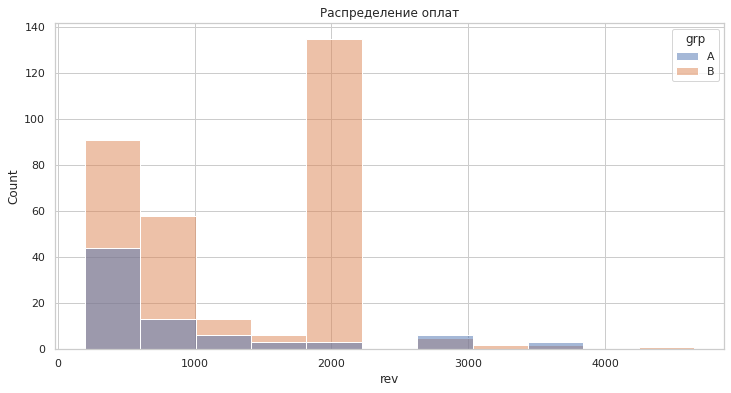

In [26]:
sns.histplot(sample, x = 'rev', hue = 'grp', stat = 'count')
plt.title("Распределение оплат")
plt.show()

Распределение оплат далеко от нормального для обоих групп, сильно скошенно вправо.
В экспериментальной группе есть пик около 2000, и чеки выше встречаются чаще, чем в контрольной группе

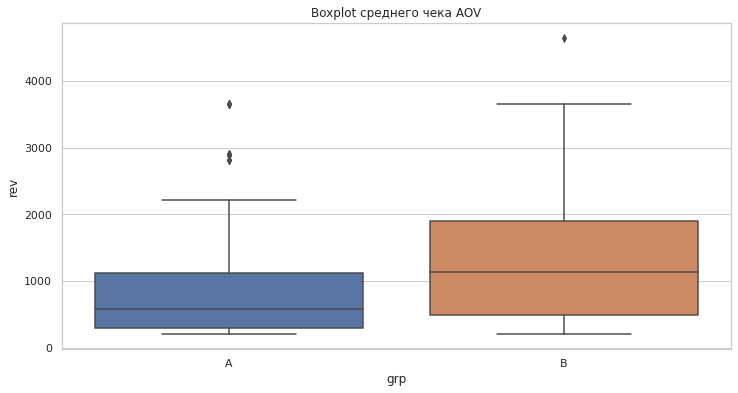

Text(0.5, 1.0, 'Violin plot среднего чека AOV')

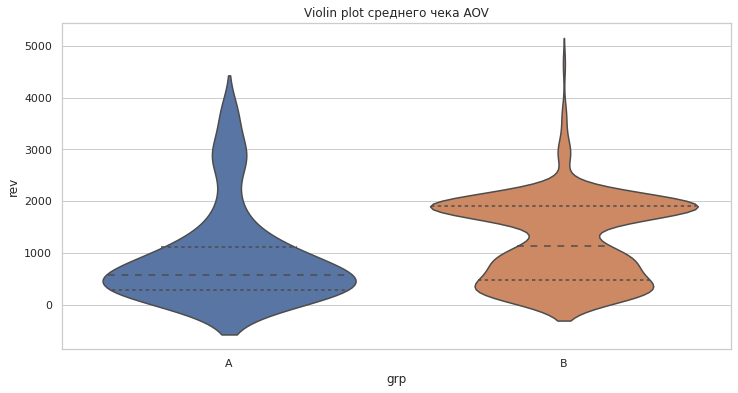

In [27]:
sns.boxplot(data=sample, x="grp", y="rev")
plt.title("Boxplot среднего чека AOV")
plt.show()

sns.violinplot(data=sample[sample["rev"].notna()], x="grp", y="rev", inner="quartile")
plt.title("Violin plot среднего чека AOV")

Медианная значение среднего чека в экспериментальной группе немного выше, чем в контрольной, в обеих группах есть выбросы, у экспериментальной группы больше разброс (вариативность).
На первый взгляд в экспериментальной группе платили больше, чем в контрольной. В контрольной группе плотность концентрируется у меньших значений (до 1000), в экспериментальной группе есть горб около 1500-2000.

### Выбор статистического критерия для всех метрик

#### Основная метрика - Конверсия в оплату CR
- Метрика бинарная: платил / не платил (так как по данным датасета checks - на одного пользователя приходится не более одного платежа).
- Сравниваем доли двух независимых групп ((А – контроль, B – целевая группа)

Выбираю **z-test for proportions**.

Тогда нулевая гипотеза звучит так: *"Конверсия в оплату одинакова в контрольной и экспериментальной группах"*

Определю 95%-й доверительный интервал

#### Прокси-метрика: Средняя выручка на одного пользователя ARPU

- Для оценки t-test требуется соблюдение условий:
1. независимость налюдений, корректная рандомизация A/B-групп - сделаем допущение, что всё так и есть.
2. нормальность распределения средних значений - есть большая масса нулевых значений, тяжелый правый хвост.
3. равенство дисперсий (гомоскедастичность)

Проверю гипотезу на равенство дисперсий тестом Левина:

In [28]:
# дисперсии по выручке
rev_A = sample.loc[sample['grp'] == 'A', 'rev'].fillna(0)
rev_B = sample.loc[sample['grp'] == 'B', 'rev'].fillna(0)

# проверка равенства дисперсий (Levene’s test)
stat, pval = stats.levene(rev_A, rev_B, center='median')
print(f"p-value проверки равенства дисперсий: {pval:.4f}")

p-value проверки равенства дисперсий: 0.2329


p = 0.2329 > 0,05 это значит, что на уровне значимости 5% ошибки нет оснований отвергать гипотезу о равенстве дисперсий.

**Вывод: можно использовать t-test или Уэлш t-test как более безопасный.**

    Тогда нулевая гипотеза будет звучать как "Средняя выручка на пользователя одинакова в контрольной и экспериментальной группах"

### Расчет статистических параметров эсперимента

In [29]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import bootstrap

####  z-test for proportions для конверсии в оплату CR

In [30]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# x - количество оплат в группе, n - всего пользователей в группе
x_A, n_A = sample.query("grp == 'A'")["rev"].notna().sum(), sample.query("grp == 'A'").student_id.nunique()
x_B, n_B = sample.query("grp == 'B'")["rev"].notna().sum(), sample.query("grp == 'B'").student_id.nunique()

z, pval = proportions_ztest([x_A, x_B], [n_A, n_B])
ci_low, ci_up = confint_proportions_2indep(x_A, n_A, x_B, n_B, method='wald')

print(f"Z = {z:.3f}, p = {pval:.4f}")
print(f"95% CI (p_A - p_B): [{ci_low:.4f}, {ci_up:.4f}]")

Z = 0.792, p = 0.4281
95% CI (p_A - p_B): [-0.0073, 0.0168]


- 0.792 — довольно маленькое значение, далеко от «критических» границ(+-1.96) для 95% доверительного интервала
- p-value 0.4281 >> 0.05, значит **нет оснований отклонить нулевую гипотезу о равных конверсиях**
- **Разница в конверсиях между группами статистически незначима**

#### Welch t-test для ARPU

In [31]:
t_stat, p_welch = stats.ttest_ind(rev_B, rev_A, equal_var=False)
print(f'Welch t-test p = {p_welch:.4}')

Welch t-test p = 0.2113


На уровне значимости 5% значение p = 0.2113 > 0.05, и значит **нет достаточных оснований отклонить нулевую гипотезу "средняя выручка в группах одинакова".**

### Выводы 

Исходная гипотеза звучала так:

    "Если изменить способ оплаты на новый - более удобный и эффективный, то конверсия в оплату увеличится"

Данная гипотеза **не нашла подтверждения**: 
1. статистически значимого различия в конверсии в оплату для контрольной (А) и экспериментальной (В) группах не обнаружено.
Следовательно, введение нового метода оплаты не стимулирует увеличение оплат, не влияет на решение "купить / не купить".
2. также не найдено статистически значимого различия в средней выручке на пользователя

Проверим, достаточен ли размер выборок, чтобы зафиксировать рост на 2 п.п и какова текущая мощность теста

In [32]:
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# требуемая выборка на группу при заданном MDE
def n_for_cr(baseline, mde_abs=None, mde_rel=None, alpha=0.05, power=0.8, ratio=1.0):
    assert (mde_abs is not None) ^ (mde_rel is not None), "можно задать MDE либо в абсолютных, либо в относительных значениях"
    p1 = baseline
    p2 = p1 + mde_abs if mde_abs is not None else p1*(1 + mde_rel)
    p2 = min(max(p2, 1e-9), 1-1e-9)  # в [0,1]
    es = proportion_effectsize(p1, p2)  # Cohen's h
    n1 = NormalIndPower().solve_power(effect_size=es, alpha=alpha, power=power, ratio=ratio, alternative='two-sided')
    return ceil(n1), ceil(n1*ratio)

# мощность при имеющемся n
def power_for_cr(baseline, target, n1, n2=None, alpha=0.05):
    es = proportion_effectsize(baseline, target)
    return NormalIndPower().power(effect_size=es, nobs1=n1, alpha=alpha, ratio=(1 if n2 is None else n2/n1),
                                  alternative='two-sided')


In [33]:
# требуемая выборка на группу при росте CR c 0.050814 до 0.07 (MDE=+1.9 п.п.), power=80%
nA, nB = n_for_cr(baseline=0.050814, mde_abs=0.07 - 0.050814, alpha=0.05, power=0.80, ratio=1.0)
# мощность при текущих n и эффекте 0.05 → 0.10
pw = power_for_cr(baseline=0.050814, target=0.07, n1=1535, n2=6793, alpha=0.05)

In [34]:
nA, nB

(2406, 2406)

In [35]:
pw

0.8155090371495997

1. Мощность теста 82% для того, чтобы зафиксировать рост на 2 п.п.
2. Размера экспериментальной выборки достаточно, чтобы зафиксировать эффект роста на 2 п.п..

    "Стоит ли запускать новую механику на всех пользователей?"
Результаты A/B-тестирования показывают, что новая механика оплаты не влияет на конверсию в оплату и  не увеличивает среднюю выручку.
__Не рекомендуется запускать новую механику на всех пользователей.__

## Задание 3
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Краткий разведочный анализ файла дополнительных данных

In [36]:
add = pd.read_csv('/home/karpov/FinalProject/group_add.csv',sep=',', index_col=None)

In [37]:
add.grp.value_counts() #как распределились пользователи по группам

B    70
A    22
Name: grp, dtype: int64

In [38]:
count = add['id'].isin(checks['student_id']).sum() #только одна оплата встречается для пользователей добавочного файла
print(count) 

1


In [39]:
count = add['id'].isin(studs['student_id']).sum() #только 13 пользователей из добавного файла принимали участие в эксперименте
print(count)

13


### Функции добавления новых данных в расчет A/B-теста

Последовательность функций должна быть такая:
- загрузить файл
- распознать в нем нужные столбцы id и grp
- выбрать в нем записи о тех пользователях, которые заходили на платформу во время эксперимента (studs)
- к этим записям добавить информацию об оплатах (checks)
- добавить эти записи в датасет sample
- рассчитать метрики и стат.критерии по ним
- построить графики по обновленным данным

In [40]:
# функция загрузки файла, если сделать допущение, что датасет будет их 2х столбцов, причем первый - id, второй - принадлежность к группе
def load_file(path):
    df = pd.read_csv(path, sep=None, engine="python")
    first, second = df.columns[:2]
    df = df.rename(columns={first: "student_id", second: "grp"}) # задам нужные имена столбцам
    df["student_id"] = pd.to_numeric(df["student_id"], errors="coerce").astype("Int64") #приведу столбец student_id к типу integer
    df["grp"] = df["grp"].astype(str).str.upper().str.strip() #данные столбца grp будут все в верхнем регистре и без пробелов
    return df.dropna(subset=["student_id", "grp"]) #убираю Nan данные из датасета

In [41]:
add = load_file('group_add.csv')
add

,student_id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


функция сборки  датасета должна выполнять следующее:

- выбрать из загруженного датасета записи о тех пользователях, которые заходили на платформу во время эксперимента (studs)
- к этим записям добавить информацию об оплатах (checks)
- добавить эти записи в датасет sample

In [42]:
def build_dataset(sample, studs, checks_clean, add):
    newbies = add.merge(studs, how = 'left',  on='student_id').merge(checks,how = 'left', on ='student_id')
    new_df = (pd.concat([sample, newbies], ignore_index=True, sort=False)
            .drop_duplicates(subset=["student_id"], keep="last"))
    return new_df

In [43]:
new_df = build_dataset(sample, studs, checks_clean, add)

функция расчета метрик: PCR, z-test for proportions для PCR, RPU и bootstrap средних для RPU

немного меняю последовательность функций:
сначала рассчитаю векторы данных, чтобы иметь возможность по ним и посчитать стат.критерии, и визуализацию построить в отдельных функциях

In [44]:
def precompute_artifacts(df, group_col="grp", user_col="student_id", rev_col="rev"):
    d = df[[group_col, user_col, rev_col]].copy()
    d[rev_col] = pd.to_numeric(d[rev_col], errors="coerce")

    # для CR
    xA = d.loc[d[group_col].eq("A"), rev_col].notna().sum()
    nA = d.loc[d[group_col].eq("A"), user_col].nunique()
    xB = d.loc[d[group_col].eq("B"), rev_col].notna().sum()
    nB = d.loc[d[group_col].eq("B"), user_col].nunique()

    # для ARPU (нули для неплативших)
    arpu_A = d.loc[d[group_col].eq("A"), rev_col].fillna(0.0).to_numpy()
    arpu_B = d.loc[d[group_col].eq("B"), rev_col].fillna(0.0).to_numpy()

    # для ARPPU (только платившие)
    arppu_A = d.loc[d[group_col].eq("A") & d[rev_col].notna(), rev_col].to_numpy()
    arppu_B = d.loc[d[group_col].eq("B") & d[rev_col].notna(), rev_col].to_numpy()

    return {"df": d, "xA": xA, "nA": nA, "xB": xB, "nB": nB,
            "arpu_A": arpu_A, "arpu_B": arpu_B, "arppu_A": arppu_A, "arppu_B": arppu_B}

Функция расчета метрик и стат.тестов

In [45]:
def compute_metrics_and_tests(art, n_boot=10_000, seed=34):
    d = art["df"]

    # сначала рассчитываю метрики
    CR = (d.assign(paid=d["rev"].notna().astype(int))
            .groupby("grp", as_index=False)
            .agg(users=("student_id","nunique"), payers=("paid","sum"))
            .assign(CR=lambda t: t.payers/t.users))

    ARPU = (d.assign(rev0=d["rev"].fillna(0.0))
             .groupby("grp", as_index=False)
             .agg(revenue=("rev0","sum"), user_count=("student_id","nunique"))
             .assign(ARPU=lambda x: x.revenue/x.user_count))

    ARPPU = (d.loc[d["rev"].notna()]
             .groupby("grp", as_index=False)
             .agg(revenue=("rev","sum"), payers=("rev","count"))
             .assign(ARPPU=lambda t: t.revenue/t.payers))
    
    # теперь рассчитываю стат/критерии для метрик
    # Z-test для CR 
    z, pval = proportions_ztest([art["xA"], art["xB"]], [art["nA"], art["nB"]])
    cr_lo, cr_hi = confint_proportions_2indep(art["xA"], art["nA"], art["xB"], art["nB"], method="wald")

    # перевожу строки в массивы для расчета t-test
    arpu_A = np.asarray(art["arpu_A"], dtype=float)
    arpu_B = np.asarray(art["arpu_B"], dtype=float)

    #Welch t-test для ARPU (Δ = B − A)
    t_stat, p_welch = stats.ttest_ind(arpu_B, arpu_A, equal_var=False)
    arpu_obs = arpu_B.mean() - arpu_A.mean()


    reports = {
        "CR": f"Z = {z:.3f}, p = {pval:.4f}\n95% CI (p_A − p_B): [{cr_lo:.4f}, {cr_hi:.4f}]",
        "ARPU": f"Welch t-test: t = {t_stat:.3f}, p = {p_welch:.4g}\n",
    }

    return {
        "CR": CR, "ARPU": ARPU, "ARPPU": ARPPU,
        "reports": reports,
        "tests": {
            "CR":   {"z": float(z), "p": float(pval), "ci_diff": (float(cr_lo), float(cr_hi))},
            "ARPU": {"welch_t": float(t_stat), "welch_p": float(p_welch)},
        },
    }

In [46]:
#построить виолин по группам для выручки ARPU
def plot_violin_paid(df, group_col="grp", value_col="rev"):
    payers = df[df[value_col].notna()]
    plt.figure()
    sns.violinplot(data=payers, x=group_col, y=value_col, inner="quartile")
    plt.title("Violinplot выручки на пользователя (только платившие)")
    plt.tight_layout(); plt.show()

# построить гистограмму конверсии
def plot_cr_bars_from_art(art, colors = ("cornflowerblue", "sandybrown")):
    xA = int(art["xA"]); nA = int(art["nA"])
    xB = int(art["xB"]); nB = int(art["nB"])
    if nA == 0 or nB == 0:
        raise ValueError("nA и nB должны быть > 0")
        
    pA, pB = xA / nA, xB / nB
    z = 1.96  # ~95% CI
    errA = z * np.sqrt(pA*(1-pA)/nA)
    errB = z * np.sqrt(pB*(1-pB)/nB)

    plt.figure()
    plt.bar(['A','B'], [pA, pB], color=list(colors),  yerr=[errA, errB], capsize=6)
    for i,(p,x,n) in enumerate([(pA,xA,nA),(pB,xB,nB)]):
        plt.text(i, p, f'{p:.2%}\n{x}/{n}', ha='center', va='bottom')
    plt.ylabel('CR'); plt.title('CR по группам ± 95% CI')
    plt.ylim(0, max(pA,pB) + max(errA,errB) + 0.05)
    plt.tight_layout(); plt.show()

оркестратор запустит последовательно расчет метрик, стат.критериев и отрисовку графиков

,grp,users,payers,CR
0,A,1557,78,0.050096
1,B,6863,314,0.045753


,grp,revenue,user_count,ARPU
0,A,72820.0,1557,46.769428
1,B,394974.0,6863,57.551217


,grp,revenue,payers,ARPPU
0,A,72820.0,78,933.589744
1,B,394974.0,314,1257.878981


Z = 0.734, p = 0.4627
95% CI (p_A − p_B): [-0.0076, 0.0163] 

Welch t-test: t = 1.310, p = 0.1904



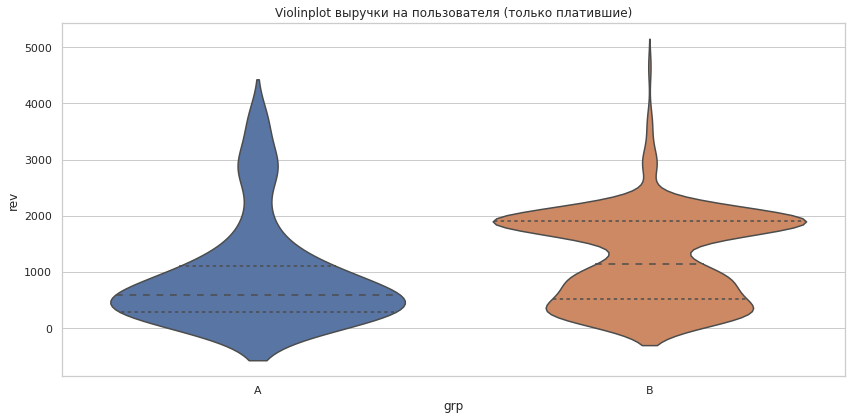

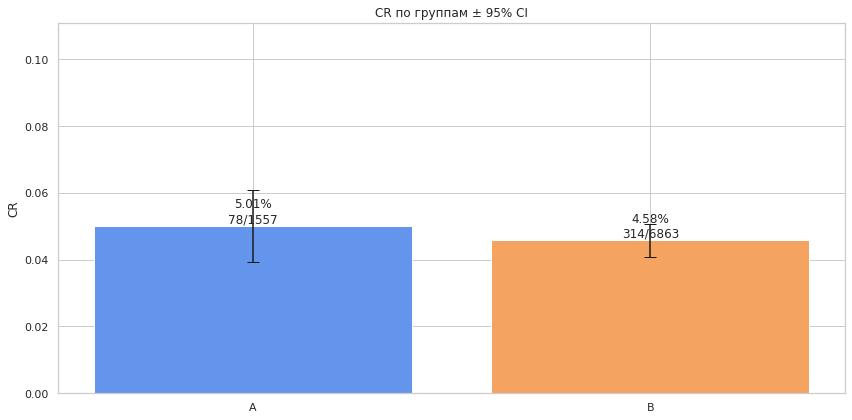

In [47]:
# я уже собрала первой функцией датасет с объединенными данными new_df со столбцами grp, student_id, rev
art = precompute_artifacts(new_df)                
res = compute_metrics_and_tests(art, n_boot=10_000, seed=34)

# рассчитать метрики + текст
display(res["CR"]); display(res["ARPU"]); display(res["ARPPU"])
print(res["reports"]["CR"], "\n") 
print(res["reports"]["ARPU"])

# построить графики:
plot_violin_paid(art["df"])
plot_cr_bars_from_art(art)

    После добавления новых данных  есть небольшие флуктуации в метриках. в большую и меньшую стоону в десятых и сотых долях, но картина в стат. критериях не изменилась для обоих метрик: p-values стат.критериев обоих метрик больше 0.05, и значит гипотезы о равенстве не отклоняются.

## Задание 2. SQL

### 2.1 Очень усердные ученики

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

    NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### 2.2 Оптимизация воронки

#### 2.2.1 Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. 
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. 
Команда провела эксперимент, где был протестирован новый экран оплаты.*/
#### 2.2.2 Задача
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

    ARPU считается относительно всех пользователей, попавших в группы.

    Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

    Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике. 